In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyPortfolioOpt arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 24.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import t
import arch
import matplotlib.pyplot as plt
from pypfopt import risk_models, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
import cvxpy as cp
import yfinance as yf
from collections import OrderedDict


Import asset class index to build weight

In [ ]:
bigcap_equities_index_raw = pd.read_csv('/content/drive/MyDrive/FIN2/Index_data/Sp500.csv', encoding='latin1')
ig_corpbonds_index_raw = pd.read_csv('/content/drive/MyDrive/FIN2/Index_data/IGCorpBond.csv', encoding='latin1')
hy_corpbonds_index_raw = pd.read_csv('/content/drive/MyDrive/FIN2/Index_data/HY_CBond.csv', encoding='latin1')
REITs_index_raw = pd.read_csv('/content/drive/MyDrive/FIN2/Index_data/US_REITs.csv', encoding='latin1')
cash_index_raw = pd.read_csv('/content/drive/MyDrive/FIN2/Index_data/cash.csv', encoding='latin1')

In [ ]:
bigcap_equities_index = bigcap_equities_index_raw.rename(columns={'Effective date ': 'Date', 'S&P 500 (TR)': 'SP500'})
ig_corpbonds_index = ig_corpbonds_index_raw.rename(columns={'Effective date ': 'Date', 'S&P 500 Investment Grade Corporate Bond Index': 'IG_CorpBond'})
hy_corpbonds_index = hy_corpbonds_index_raw.rename(columns={'Effective date ': 'Date', 'S&P U.S. High Yield Corporate Bond Index': 'HY_CorpBond'})
REITs_index = REITs_index_raw.rename(columns={'Effective date ': 'Date', 'S&P United States REIT (USD) TR': 'US_REITs'})
hy_corpbonds_os = pd.read_csv('/content/drive/MyDrive/FIN2/Index_data/HYCorpBond.csv', encoding='latin1').rename(columns={'Effective date ': 'Date', 'S&P U.S. High Yield Corporate Bond Index': 'HY_CorpBond'})
hy_corpbonds_os.Date = pd.to_datetime(hy_corpbonds_os.Date)
cash_index = cash_index_raw.rename(columns={'date': 'Date', 'Cash TR': 'cash'})

<ipython-input-5-ff3655198808>:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  hy_corpbonds_os.Date = pd.to_datetime(hy_corpbonds_os.Date)


In [ ]:
# Merging the data on 'Date'
merged_data = pd.merge(bigcap_equities_index, ig_corpbonds_index, on='Date', how='inner')
merged_data = pd.merge(merged_data, hy_corpbonds_index, on='Date', how='inner')
merged_data = pd.merge(merged_data, REITs_index, on='Date', how='inner')
merged_data = pd.merge(merged_data, cash_index, on='Date', how='inner')
merged_data.Date = pd.to_datetime(merged_data.Date)
f_cap_os = merged_data.iloc[-1]
merged_data_is = merged_data[merged_data["Date"] < "2024-01-01"]
merged_data_os = merged_data[merged_data["Date"] >= "2024-01-01"]

merged_data.set_index('Date', inplace = True)
merged_data_is.set_index('Date', inplace = True)
merged_data_os.set_index('Date', inplace = True)

portfolio_index = merged_data_is.copy()
portfolio_index_os = merged_data_os.copy()
portfolio_index_full = merged_data.copy()

k = portfolio_index.iloc[-1]/f_cap_os[1:]


<ipython-input-6-28f03630a7a1>:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_data.Date = pd.to_datetime(merged_data.Date)


In [ ]:
portfolio_index_os

,SP500,IG_CorpBond,HY_CorpBond,US_REITs,cash
Date,,,,,
2024-01-02,10269.69,453.46,684.121142,1703.96,113.344397
2024-01-03,10187.79,453.11,676.258886,1665.24,113.360523
2024-01-04,10154.20,450.62,669.621093,1662.64,113.376652
2024-01-05,10172.75,449.50,663.869813,1659.68,113.392783
2024-01-08,10316.52,451.27,669.296264,1685.55,113.441191
...,...,...,...,...,...
2024-11-12,13108.95,468.40,838.034686,1905.64,118.450587
2024-11-13,13112.57,466.91,834.255794,1916.86,118.465121
2024-11-14,13034.79,466.29,830.992501,1895.57,118.479657


In [ ]:
(100*portfolio_index_os['cash'] / portfolio_index_os['cash'].iloc[0]).iloc[-1]

104.58198158661517

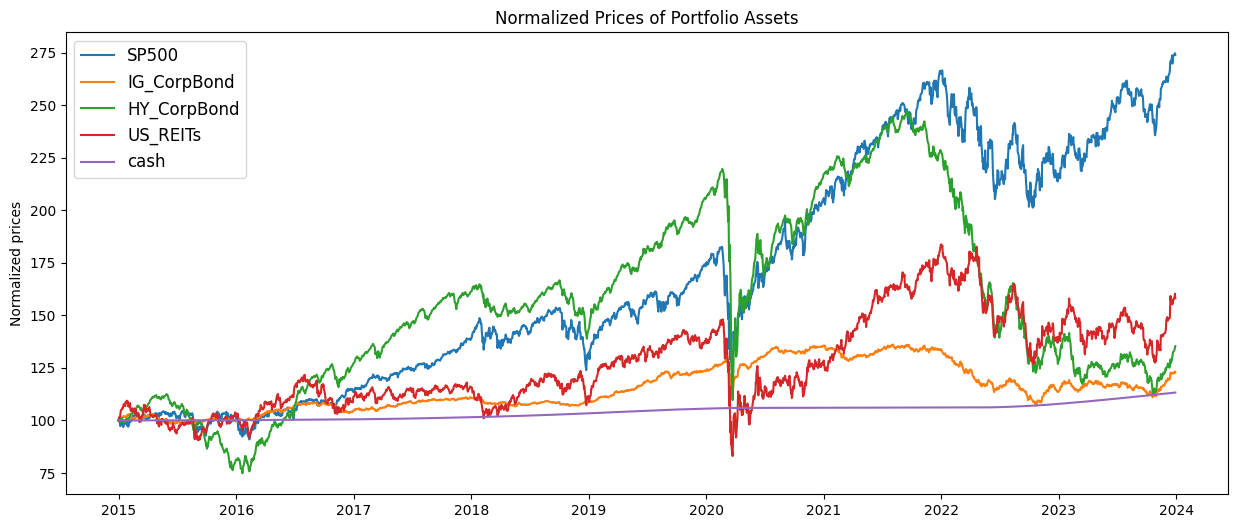

In [ ]:
# Normalize the portfolio index to start at 100
normalized_portfolio_index = 100*portfolio_index / portfolio_index.iloc[0]

plt.figure(figsize=(15, 6))

for i in range(normalized_portfolio_index.shape[1]):
    plt.plot(normalized_portfolio_index.iloc[:, i], label=normalized_portfolio_index.columns[i])

plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Normalized prices')
plt.title('Normalized Prices of Portfolio Assets')
plt.show()

In [ ]:
portfolio = pd.DataFrame({'SP500': portfolio_index.SP500.pct_change(),
                   'IG_CorpBond': portfolio_index.IG_CorpBond.pct_change(),
                   'HY_CorpBond': portfolio_index.HY_CorpBond.pct_change(),
                   'US_REITs': portfolio_index.US_REITs.pct_change(),
                   'cash': portfolio_index.cash.pct_change()}).dropna()*100

In [ ]:
portfolio_os = pd.DataFrame({'SP500': portfolio_index_os.SP500.pct_change(),
                   'IG_CorpBond': portfolio_index_os.IG_CorpBond.pct_change(),
                   'HY_CorpBond': portfolio_index_os.HY_CorpBond.pct_change(),
                   'US_REITs': portfolio_index_os.US_REITs.pct_change(),
                   'cash': portfolio_index_os.cash.pct_change()}).dropna()*100

In [ ]:
portfolio_full = pd.DataFrame({'SP500': portfolio_index_full.SP500.pct_change(),
                   'IG_CorpBond': portfolio_index_full.IG_CorpBond.pct_change(),
                   'HY_CorpBond': portfolio_index_full.HY_CorpBond.pct_change(),
                   'US_REITs': portfolio_index_full.US_REITs.pct_change(),
                   'cash': portfolio_index_full.cash.pct_change()}).dropna()*100

### DCC-copula

In [ ]:
# @title
#--------------------------------------------------------------------------------- MATRIX-GENERATING FUNCTIONS --------------------------------------------------------------------

def Q_average(tr):
    # return average of outer product of [eT-1,...e0]
    # et = [r(1t)/s(1t),...r(nt)/s(nt)]
    T = tr.shape[1]
    n = tr.shape[0]
    sum = np.zeros([n,n])
    for i in range(T):
        sum += np.outer(tr[:,i],tr[:,i])
    return sum/T

def Q_gen(tr,ab):
    # generate [Q0,...QT-1] -- assume Q0 = Q_int
    Q_int = Q_average(tr)
    Q_list = [Q_int]
    T = tr.shape[1]
    a = ab[0]
    b = ab[1]
    for i in range(1,T):
        et_1 = tr[:,i-1]
        Qt_1 = Q_list[i-1]
        Qt = (1.0-a-b)*Q_int + a*np.outer(et_1,et_1) + b*Qt_1
        Q_list = Q_list + [Qt]
    return Q_list

def R_gen(tr,ab): #Qt --> Rt
    # output [R0,...RT-1]
    Q_list = Q_gen(tr,ab)
    R_list = []
    n = Q_list[0].shape[0]
    for Qt in Q_list:
        Q_star = np.sqrt(np.diag(1/np.diag(Qt + 1e-10)))
        Rt = Q_star @ Qt @ Q_star
        R_list = R_list + [Rt]
    return R_list

def D_gen(sigma):
    D_list = np.array([np.diag(sigma[:, i]) for i in range(sigma.shape[1])])
    return D_list

def H_gen(D, R):
    H_list = np.array([np.dot(np.dot(D[i], R[i]), D[i]) for i in range(len(R))])
    return H_list

def H_sqrt_gen(H):
    H_sqrt_list = np.array([np.linalg.cholesky(H[i]) for i in range(len(H))])
    return H_sqrt_list


#----------------------------------------------------------------------------- CORRELATION-MATRIX FUNCTIONS -----------------------------------------------------------------------------------

def vecl(matrix):
    lower_matrix = np.tril(matrix,k=-1)
    array_with_zero = np.matrix(lower_matrix).A1

    array_without_zero = array_with_zero[array_with_zero!=0]

    return array_without_zero

def Corr_data(tr, ab):
    N, T = int(tr.shape[0]), int(tr.shape[1])
    veclRt =  np.zeros((T, int(N*(N-1)/2)))
    Rt= R_gen(tr,ab)
    for j in range(0,T):
      veclRt[j, :] = vecl(Rt[j])
    return veclRt

#------------------------------------------------------------------------------ LOSS-FUNCTIONS -------------------------------------------------------------------------------------------------

# This is loss function
def loglike_norm_dcc_copula(ab, udata):
    N, T = int(udata.shape[0]), int(udata.shape[1])
    llf = np.zeros((T,1))
    trdata = np.array(norm.ppf(udata), ndmin=2)

    Rt =  R_gen(trdata, ab)

    for i in range(0,T):
        llf[i] = -0.5* np.log(np.linalg.det(Rt[i]))
        llf[i] = llf[i] - 0.5 *  np.matmul(np.matmul(trdata[:,i] , (np.linalg.inv(Rt[i]) - np.eye(N))) ,trdata[:,i].T)
    llf = np.sum(llf)

    return -llf

#------------------------------------------------------------------------------- COPULA-FUNCTIONS ----------------------------------------------------------------------------------------------

# Transform t-distribution to a uniform distribution
def garch_t_to_u(rets, garch_results):
    mu = garch_results.params['mu']
    nu = garch_results.params['nu']
    est_r = rets - mu
    h = garch_results.conditional_volatility
    std_res = est_r / h
    std_res = garch_results.std_resid
    udata = t.cdf(std_res, nu)
    return udata

In [ ]:
# @title
class DCC():

    def __init__(self, max_itr=2):
        self.max_itr = max_itr
        self.ab = np.array([0.05, 0.95])
        self.method =  'SLSQP'
        self.Qt = None
        self.Rt = None
        self.Dt = None
        self.Ht = None
        self.H_sqrt_t = None
        self.loss_func = None
        def ub(x):
            return 1. - x[0] - x[1]
        def lb1(x):
            return x[0]
        def lb2(x):
            return x[1]
        self.cons = [{'type':'ineq', 'fun':ub},{'type':'ineq', 'fun':lb1},{'type':'ineq', 'fun':lb2}]
        self.bnds = ((0, 0.5), (0, 0.9997))
        self.epsilon = None

    def set_ab(self,ab): # ndarray
        self.ab = ab

    def set_method(self,method):
        self.method = method

    def set_loss(self, loss_func):
        self.loss_func = loss_func

    def get_loss_func(self):
        if self.loss_func is None:
            raise Exception("No Loss Function Found!")
        else:
            return self.loss_func

    def run_garch_on_return(self, rets):
        udata_list = []
        model_parameters = {}
        for x in rets:
            am = arch.arch_model(rets[x], vol='Garch', p=1, q=1, o=1, dist = 't')
            stock_code = x.split('_')[0]
            model_parameters[stock_code] = am.fit(disp='off')
            udata = garch_t_to_u(rets[x], model_parameters[stock_code])
            udata_list.append(udata)
        udata_list = np.array(udata_list)
        return udata_list, model_parameters

    def fit(self, train_data):

        udata_list, model_parameters = self.run_garch_on_return(train_data)

        tr = udata_list

        # Optimize using scipy and save theta
        tr_losses = []
        j = 0
        count = 0
        while j < self.max_itr:
            j += 1
            ab0 = np.array(self.ab)
            res = minimize(self.get_loss_func(), ab0, args = (tr,), bounds=self.bnds, constraints=self.cons)
            ab = res.x
            self.set_ab(ab)

            tr_loss = self.get_loss_func()(ab,tr)
            tr_losses.append(tr_loss)

        print("Successfully Trained!")

        epsilon = np.array(norm.ppf(udata_list), ndmin=2)
        sigma = np.array([np.array(model_parameters[i.split('_')[0]].conditional_volatility) for i in train_data])
        self.epsilon = epsilon
        self.Ht = self.H_t(epsilon, sigma)

        return tr_losses

    def Ht_forecast(self, test_data):
        udata_list, model_parameters = self.run_garch_on_return(test_data)
        epsilon = np.array(norm.ppf(udata_list), ndmin=2)
        sigma = np.array([np.array(model_parameters[i.split('_')[0]].conditional_volatility) for i in test_data])
        H_t_forecasted = self.H_t(epsilon, sigma)
        return H_t_forecasted

    def Q(self,y):
        self.Qt = np.array(Q_gen(y,self.ab))
        return self.Qt

    def Q_bar(self,y):
        return Q_average(y)

    def R_t(self, y):
        self.Rt = np.array(R_gen(y,self.ab))
        return self.Rt

    def D_t(self, sigma):
        self.Dt = D_gen(sigma)
        return self.Dt

    def H_t(self, y, sigma):
        Dt = np.array(D_gen(sigma))
        Rt = np.array(R_gen(y,self.ab))
        Ht = H_gen(Dt, Rt)
        return Ht

    def H_sqrt_t(self, y, sigma):
        self.Dt = D_gen(sigma)
        self.Rt = np.array(R_gen(y,self.ab))
        self.Ht = H_gen(self.Dt, self.Rt)
        self.H_sqrt_t = H_sqrt_gen(self.Ht)
        return self.H_sqrt_t


In [ ]:
dcc_model = DCC()
dcc_model.set_loss(loglike_norm_dcc_copula)
dcc_model.fit(portfolio.copy()*100)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.338e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.029e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarn

Successfully Trained!


[-1024.406062080949, -1024.4060621567164]

In [ ]:
ab = dcc_model.ab
ab

array([0.02033582, 0.96726041])

In [ ]:
H_t = dcc_model.Ht/1000000
latest_H_t = H_t[-1]

# Define labels for rows and columns
labels = ["SP500", "IG_CorpBond", "HY_CorpBond", "US_REITs", "cash"]

# Convert to DataFrame
cov_matrix_DCC = pd.DataFrame(latest_H_t, index=labels, columns=labels)

In [ ]:
cov_matrix_his = risk_models.sample_cov(portfolio_index)

In [ ]:
cov_matrix_shrinkage = risk_models.CovarianceShrinkage(portfolio_index).ledoit_wolf()

### New Section

In [ ]:
SP500_mktcap_os = 100393.36*503
IG_CorpBond_mktcap_os = 5575261.02
HY_CorpBond_mktcap_os = 1633521.20
US_REITs_mktcap_os = 9110.74*136
cash_mktcap_os = 801850
k_1 = (15.09/21.87)**(1/1500)
k_2 = (9.68/15.8)**(1/2750)

In [ ]:
SP500_mktcap = SP500_mktcap_os*k[0]
IG_CorpBond_mktcap = IG_CorpBond_mktcap_os*k[1]
HY_CorpBond_mktcap = HY_CorpBond_mktcap_os*k[2]
US_REITs_mktcap = US_REITs_mktcap_os*k[3]
cash_mktcap = cash_mktcap_os*k[4]

<ipython-input-21-e41ffc6c206f>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SP500_mktcap = SP500_mktcap_os*k[0]
<ipython-input-21-e41ffc6c206f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IG_CorpBond_mktcap = IG_CorpBond_mktcap_os*k[1]
<ipython-input-21-e41ffc6c206f>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  HY_CorpBond_mktcap = HY_CorpBond_mktcap_os*k[2]
<ipython-input-21-e41ffc6c206f>:4: FutureWarning: Series.__ge

In [ ]:
total_mktcap = SP500_mktcap + IG_CorpBond_mktcap + HY_CorpBond_mktcap + US_REITs_mktcap + cash_mktcap

# Calculate market cap weights
marketcap_weights = OrderedDict({
    'SP500': SP500_mktcap / total_mktcap,
    'IG_CorpBond': IG_CorpBond_mktcap / total_mktcap,
    'HY_CorpBond': HY_CorpBond_mktcap / total_mktcap,
    'US_REITs': US_REITs_mktcap / total_mktcap,
    'cash': cash_mktcap / total_mktcap
})

In [ ]:
cov_matrix_DCC

,SP500,IG_CorpBond,HY_CorpBond,US_REITs,cash
SP500,0.004406,0.000532,0.001116,0.004384,0.000022
IG_CorpBond,0.000532,0.002050,0.001305,0.002058,0.000007
HY_CorpBond,0.001116,0.001305,0.002491,0.002411,0.000020
US_REITs,0.004384,0.002058,0.002411,0.010505,0.000029
cash,0.000022,0.000007,0.000020,0.000029,0.000008


In [ ]:
np.sqrt(cov_matrix_DCC)*100

,SP500,IG_CorpBond,HY_CorpBond,US_REITs,cash
SP500,6.637631,2.306676,3.340672,6.621252,0.473862
IG_CorpBond,2.306676,4.527489,3.612093,4.536748,0.263534
HY_CorpBond,3.340672,3.612093,4.991273,4.909716,0.445312
US_REITs,6.621252,4.536748,4.909716,10.249554,0.536602
cash,0.473862,0.263534,0.445312,0.536602,0.285423


In [ ]:
cov_matrix_his

,SP500,IG_CorpBond,HY_CorpBond,US_REITs,cash
SP500,0.033734,1.222209e-04,0.014454,0.029542,-1.729250e-06
IG_CorpBond,0.000122,3.250142e-03,0.003742,0.002419,-6.671560e-07
HY_CorpBond,0.014454,3.741651e-03,0.025935,0.016358,3.034002e-06
US_REITs,0.029542,2.419241e-03,0.016358,0.048334,-3.418329e-06
cash,-0.000002,-6.671560e-07,0.000003,-0.000003,1.599807e-06


In [ ]:
# Define liquidity scores
liquidity_scores = {
    "SP500": 0.8,
    "IG_CorpBond": 0.7,
    "HY_CorpBond": 0.65,
    "US_REITs": 0.65,
    "cash": 1,
}

# Add a helper function to compute liquidity score
def portfolio_liquidity(weights, liquidity_scores):
    return sum(weights[i] * score for i, score in enumerate(liquidity_scores.values()))

In [ ]:
def optimal_asset_weights(covar_matrix = None, min_cash_need = 0.0, min_liquidity_need = 0.0, max_vol = 1):

    # Initialize the Black-Litterman model
    views = {"SP500": 0.1, "IG_CorpBond": 0.058, "HY_CorpBond": 0.075, "US_REITs": 0.15, "cash": 0}
    market_cap = {"SP500": SP500_mktcap, "IG_CorpBond": IG_CorpBond_mktcap, "HY_CorpBond": HY_CorpBond_mktcap, "US_REITs": US_REITs_mktcap, "cash": cash_mktcap}
    bl = BlackLittermanModel(
        covar_matrix,
        pi="market",
        absolute_views=views,
        market_caps=market_cap,
    )
    expected_returns = bl.bl_returns()

    # Initialize the Efficient Frontier
    ef = EfficientFrontier(expected_returns, covar_matrix)

    # Add constraints
    # 1. Maximum volatility (standard deviation)
    max_volatility = max_vol
    ef.add_constraint(lambda w: w.T @ covar_matrix @w <= max_volatility**2)

    # 2. Minimum liquidity
    ef.add_constraint(lambda w: portfolio_liquidity(w, liquidity_scores) >= min_liquidity_need)

    # 3. Minimum cash allocation
    cash_index = list(views.keys()).index("cash")
    ef.add_constraint(lambda w: w[cash_index] >= min_cash_need)

    # Optimize the portfolio by conditional drawdown
    weights = ef.max_sharpe()

    # Display results
    cleaned_weights = ef.clean_weights()
    performance = ef.portfolio_performance(verbose=True)

    return cleaned_weights, performance, expected_returns

In [ ]:
weights_DCC_6, performance_6, expected_returns_DCC = optimal_asset_weights(covar_matrix = cov_matrix_DCC, min_cash_need = 0.05, min_liquidity_need = 0.5, max_vol = 1)
weights_DCC_7, performance_7, expected_returns_DCC = optimal_asset_weights(covar_matrix = cov_matrix_DCC, min_cash_need = 0.1, min_liquidity_need = 0.6, max_vol = 1)
weights_DCC_8, performance_8, expected_returns_DCC = optimal_asset_weights(covar_matrix = cov_matrix_DCC, min_cash_need = 0.2, min_liquidity_need = 0.7, max_vol = 1)
weights_DCC_9, performance_9, expected_returns_DCC = optimal_asset_weights(covar_matrix = cov_matrix_DCC, min_cash_need = 0.3, min_liquidity_need = 0.8, max_vol = 1)

weights_his_6, performance_6_his, expected_returns_his = optimal_asset_weights(covar_matrix = cov_matrix_his, min_cash_need = 0.05, min_liquidity_need = 0.5, max_vol = 1)
weights_his_7, performance_7_his, expected_returns_his = optimal_asset_weights(covar_matrix = cov_matrix_his, min_cash_need = 0.1, min_liquidity_need = 0.6, max_vol = 1)
weights_his_8, performance_8_his, expected_returns_his = optimal_asset_weights(covar_matrix = cov_matrix_his, min_cash_need = 0.2, min_liquidity_need = 0.7, max_vol = 1)
weights_his_9, performance_9_his, expected_returns_his = optimal_asset_weights(covar_matrix = cov_matrix_his, min_cash_need = 0.3, min_liquidity_need = 0.8, max_vol = 1)

weights_shrinkage_6, performance_6_shrinkage, expected_returns_shrinkage = optimal_asset_weights(covar_matrix = cov_matrix_shrinkage, min_cash_need = 0.05, min_liquidity_need = 0.5, max_vol = 1)
weights_shrinkage_7, performance_7_shrinkage, expected_returns_shrinkage = optimal_asset_weights(covar_matrix = cov_matrix_shrinkage, min_cash_need = 0.1, min_liquidity_need = 0.6, max_vol = 1)
weights_shrinkage_8, performance_8_shrinkage, expected_returns_shrinkage = optimal_asset_weights(covar_matrix = cov_matrix_shrinkage, min_cash_need = 0.2, min_liquidity_need = 0.7, max_vol = 1)
weights_shrinkage_9, performance_9_shrinkage, expected_returns_shrinkage = optimal_asset_weights(covar_matrix = cov_matrix_shrinkage, min_cash_need = 0.3, min_liquidity_need = 0.8, max_vol = 1)

Expected annual return: 5.7%
Annual volatility: 4.3%
Sharpe Ratio: 1.33
Expected annual return: 5.4%
Annual volatility: 4.1%
Sharpe Ratio: 1.33
Expected annual return: 4.8%
Annual volatility: 3.6%
Sharpe Ratio: 1.33
Expected annual return: 4.1%
Annual volatility: 3.1%
Sharpe Ratio: 1.33
Expected annual return: 3.4%
Annual volatility: 4.8%
Sharpe Ratio: 0.69
Expected annual return: 3.4%
Annual volatility: 4.8%
Sharpe Ratio: 0.69
Expected annual return: 3.4%
Annual volatility: 4.8%
Sharpe Ratio: 0.69
Expected annual return: 3.0%
Annual volatility: 4.3%
Sharpe Ratio: 0.69
Expected annual return: 4.3%
Annual volatility: 6.3%
Sharpe Ratio: 0.68
Expected annual return: 4.1%
Annual volatility: 6.0%
Sharpe Ratio: 0.68
Expected annual return: 3.6%
Annual volatility: 5.4%
Sharpe Ratio: 0.68
Expected annual return: 3.1%
Annual volatility: 4.7%
Sharpe Ratio: 0.67


In [ ]:
def Port_period_perfomance(port_perfomance):
    expected_return = port_perfomance[0]
    expected_vol = port_perfomance[1]
    periods = [6, 12, 20, 30]
    min_prob = [0.9, 0.8, 0.7, 0.6]
    t_stat = [1.28, 0.84, 0.52, 0.25 ]
    _dict = {'6': None, '12': None, '20': None, '30': None}
    for period in periods:
      for i in range(len(min_prob)):
          expected_return_dis = expected_return*period
          vol_dis = expected_vol*np.sqrt(period)
          required_return = (expected_return_dis-vol_dis*t_stat[i])/period
          if _dict[str(period)] == None:
            _dict[str(period)] = [round(required_return*100,2)]
          else:
            _dict[str(period)].append(round(required_return*100,2))
    return _dict

In [ ]:
Port_period_perfomance(performance_6_shrinkage)

{'6': [1.0, 2.14, 2.97, 3.67],
 '12': [1.98, 2.78, 3.37, 3.86],
 '20': [2.5, 3.13, 3.58, 3.97],
 '30': [2.84, 3.35, 3.72, 4.03]}

In [ ]:
Port_period_perfomance(performance_8)

{'6': [2.93, 3.58, 4.05, 4.45],
 '12': [3.48, 3.94, 4.28, 4.56],
 '20': [3.79, 4.14, 4.4, 4.62],
 '30': [3.98, 4.27, 4.48, 4.66]}

In [ ]:
def portfolio_os_testing(weights, returns):
    weight_array = np.array(list(weights.values()))
    portfolio_returns = returns.dot(weight_array)
    portfolio_volatility = portfolio_returns.std()*np.sqrt(252)
    portfolio_sharpe = portfolio_returns.mean()*252/portfolio_volatility
    return portfolio_sharpe, portfolio_returns, portfolio_volatility

In [ ]:
# @title
def monte_carlo_simulation(e_returns, cov_matrix, weight, num_simulations=10000):

    # 1. Define the Inputs

    mu = e_returns # Expected returns for each asset (example)
    Sigma = cov_matrix  # Covariance matrix
    w = np.array(list(weight.values())) # Portfolio weights
    N = num_simulations # Number of simulations


    # Constraint: Asset [-1] (i.e., the last asset) return should not fall below 0
    threshold = 0

    # 2. Generate Random Portfolio Returns with Constraint
    simulated_returns = []

    for _ in range(N):
        # Generate a random vector of returns for the assets
        r = np.random.multivariate_normal(mu, Sigma)

        # Check if the return of the last asset falls below the threshold
        while r[-1] < threshold:
            r = np.random.multivariate_normal(mu, Sigma)

        # Append valid returns to the list
        simulated_returns.append(r)

    # Convert to NumPy array for convenience
    simulated_returns = np.array(simulated_returns)

    # 3. Calculate Portfolio Returns for each simulation
    portfolio_returns = np.dot(simulated_returns, w)

    # 4. Analyze Results
    mean_portfolio_return = np.mean(portfolio_returns)
    std_portfolio_return = np.std(portfolio_returns)

    # Print summary statistics
    print(f"Mean Portfolio Return: {mean_portfolio_return:.4f}")
    print(f"Portfolio Return Standard Deviation: {std_portfolio_return:.4f}")

    # 5. Plot the Distribution of Portfolio Returns
    plt.hist(portfolio_returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Monte Carlo Simulation of Portfolio Returns')
    plt.xlabel('Portfolio Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# @title
def aggregate_portfolios(proportions, *weights):

    # Check that proportions sum to 1 (100%)
    if sum(proportions) != 1:
        raise ValueError("Proportions must sum to 1.")

    # Initialize the aggregated portfolio with zero values
    aggregated_weights = OrderedDict()

    # Iterate over each portfolio and its corresponding proportion
    for i, weight_dict in enumerate(weights):
        if i == 0:
            # Initialize aggregated_weights with the first portfolio
            aggregated_weights = OrderedDict((key, value * proportions[i])
                                             for key, value in weight_dict.items())
        else:
            # Update the aggregated_weights by adding the weighted portfolio values
            for key, value in weight_dict.items():
                aggregated_weights[key] += value * proportions[i]
    aggregated_weights = OrderedDict((key, round(value,4)) for key, value in aggregated_weights.items())

    return aggregated_weights

In [ ]:
# Define the proportions for each portfolio
proportions = [0.57, 0.04, 0.02, 0.37]
bench_proportions = [0.57, 0.04, 0.02, 0.37]

# Aggregate the portfolios
aggregated_portfolio = aggregate_portfolios(proportions, weights_DCC_6, weights_DCC_7, weights_DCC_8, weights_DCC_9)
benchmark_agrre_port = aggregate_portfolios(proportions, weights_shrinkage_6, weights_shrinkage_7, weights_shrinkage_8, weights_shrinkage_9)

# Output the result
print(aggregated_portfolio)
print(benchmark_agrre_port)

OrderedDict([('SP500', 0.2381), ('IG_CorpBond', 0.2443), ('HY_CorpBond', 0.2616), ('US_REITs', 0.102), ('cash', 0.154)])
OrderedDict([('SP500', 0.1223), ('IG_CorpBond', 0.6302), ('HY_CorpBond', 0.0201), ('US_REITs', 0.0757), ('cash', 0.1518)])


In [ ]:
def portfolio_annualized_metrics(weights, expected_returns, cov_matrix):

    # Extract the values from the OrderedDict (weights)
    weight_array = np.array(list(weights.values()))
    asset_names = list(weights.keys())

    # Ensure expected_returns is in the correct format (numpy array)
    expected_returns = np.array(expected_returns)

    # Calculate the annualized expected return (weighted sum of individual asset returns)
    annualized_return = np.dot(weight_array, expected_returns)

    # Calculate the portfolio variance (w^T * Covariance Matrix * w)
    portfolio_variance = np.dot(weight_array.T, np.dot(cov_matrix, weight_array))

    # Calculate annualized volatility (sqrt of portfolio variance)
    annualized_volatility = np.sqrt(portfolio_variance)

    return annualized_return, annualized_volatility


In [ ]:
aggregated_portfolio

OrderedDict([('SP500', 0.2381),
             ('IG_CorpBond', 0.2443),
             ('HY_CorpBond', 0.2616),
             ('US_REITs', 0.102),
             ('cash', 0.154)])

In [ ]:
portfolio_annualized_metrics(aggregated_portfolio, expected_returns_DCC, cov_matrix_DCC)[1]*100

3.8322543510154765

In [ ]:
benchmark_agrre_port

OrderedDict([('SP500', 0.1223),
             ('IG_CorpBond', 0.6302),
             ('HY_CorpBond', 0.0201),
             ('US_REITs', 0.0757),
             ('cash', 0.1518)])

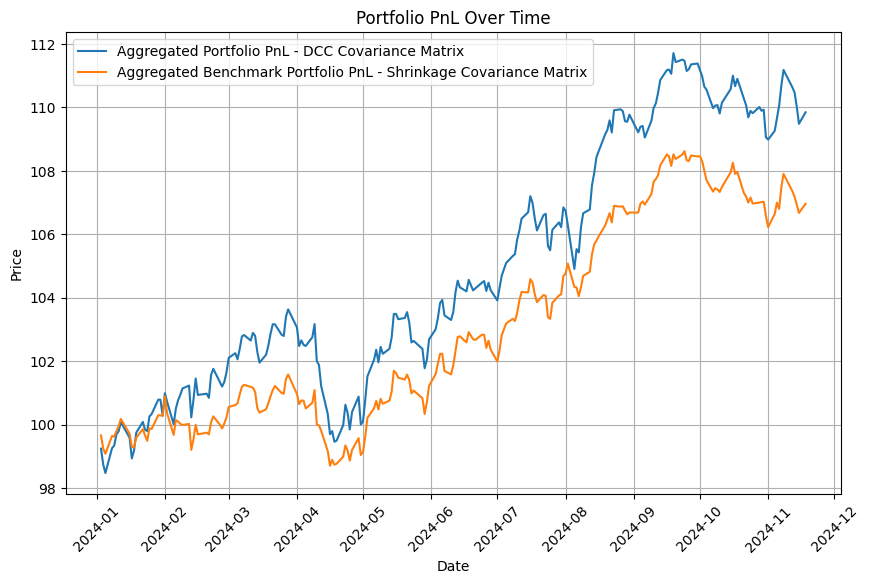

In [ ]:
# Calculate portfolio cumulative price, starting at 100
aggregated_portfolio_sharpe, aggregated_portfolio_returns, aggregated_portfolio_volatility = portfolio_os_testing(aggregated_portfolio, portfolio_os)
bench_portfolio_sharpe, bench_portfolio_returns, bench_portfolio_volatility = portfolio_os_testing(benchmark_agrre_port, portfolio_os)
aggregated_portfolio_price = 100 * ((1 + aggregated_portfolio_returns/ 100)*k_2).cumprod()
bench_portfolio_price = 100 * (1 + bench_portfolio_returns / 100).cumprod()

# Plot the portfolio price over time
plt.figure(figsize=(10, 6))
plt.plot(aggregated_portfolio_price, label="Aggregated Portfolio PnL - DCC Covariance Matrix")
plt.plot(bench_portfolio_price, label="Aggregated Benchmark Portfolio PnL - Shrinkage Covariance Matrix")
plt.title("Portfolio PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
aggregated_portfolio_volatility*aggregated_portfolio_sharpe

15.448339276157878

Mean Portfolio Return: 0.0554
Portfolio Return Standard Deviation: 0.0378


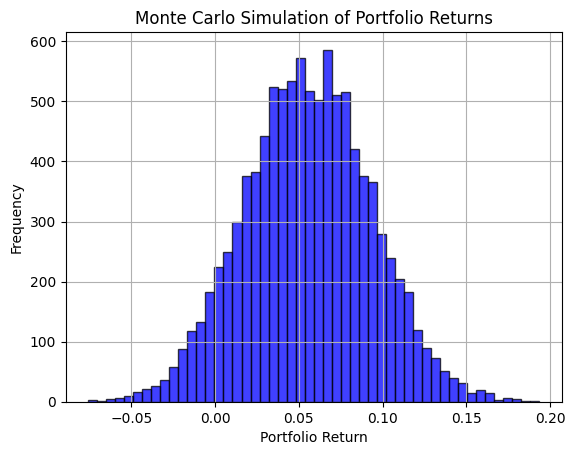

In [ ]:
monte_carlo_simulation(expected_returns_DCC, cov_matrix_DCC, aggregated_portfolio)

### Portfolio Construction

In [ ]:
def optimal_asset_weights(price_data = None, views = None, market_cap= None):

    covar_matrix = risk_models.sample_cov(price_data)

    # Initialize the Black-Litterman model
    bl = BlackLittermanModel(
        covar_matrix,
        pi="market",
        absolute_views=views,
        market_caps=market_cap,
    )
    expected_returns = bl.bl_returns()

    # Initialize the Efficient Frontier
    ef = EfficientFrontier(expected_returns, covar_matrix)

    ef.add_constraint(lambda w: w >= 0.03)  # This ensures no asset has less than 2% weight

    # Optimize the portfolio by conditional drawdown
    weights = ef.max_sharpe()

    # Display results
    cleaned_weights = ef.clean_weights()
    performance = ef.portfolio_performance(verbose=True)

    return cleaned_weights, performance, expected_returns

In [ ]:
def portfolio_os_testing(weights, returns_os):
    weight_array = np.array(list(weights.values()))
    portfolio_returns = returns_os.dot(weight_array)
    portfolio_volatility = portfolio_returns.std()*np.sqrt(252)
    portfolio_sharpe = portfolio_returns.mean()*252/portfolio_volatility
    return portfolio_sharpe, portfolio_returns, portfolio_volatility, portfolio_returns.mean()*252

In [ ]:
def value_at_risk(e_returns, cov_matrix, weight, num_simulations=10000):
    # 1. Define the Inputs
    mu = e_returns  # Expected returns for each asset
    Sigma = cov_matrix  # Covariance matrix
    w = np.array(list(weight.values()))  # Portfolio weights
    N = num_simulations  # Number of simulations

    # Constraint: Asset [-1] (i.e., the last asset) return should not fall below 0
    threshold = 0

    # 2. Generate Random Portfolio Returns with Constraint
    simulated_returns = []

    for _ in range(N):
        # Generate a random vector of returns for the assets
        r = np.random.multivariate_normal(mu, Sigma)

        # Check if the return of the last asset falls below the threshold
        while r[-1] < threshold:
            r = np.random.multivariate_normal(mu, Sigma)

        # Append valid returns to the list
        simulated_returns.append(r)

    # Convert to NumPy array for convenience
    simulated_returns = np.array(simulated_returns)

    # 3. Calculate Portfolio Returns for each simulation
    portfolio_returns = np.dot(simulated_returns, w)

    # 4. Analyze Results
    mean_portfolio_return = np.mean(portfolio_returns)
    std_portfolio_return = np.std(portfolio_returns)
    var_95 = np.percentile(portfolio_returns, 5)  # Calculate the 5th percentile

    # Print summary statistics
    print(f"Mean Portfolio Return: {mean_portfolio_return:.4f}")
    print(f"Portfolio Return Standard Deviation: {std_portfolio_return:.4f}")
    print(f"95% Value at Risk (VaR): {var_95:.4f}")

    # 5. Plot the Distribution of Portfolio Returns
    plt.hist(portfolio_returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.axvline(var_95, color='red', linestyle='dashed', linewidth=1, label='95% VaR')
    plt.title('Monte Carlo Simulation of Portfolio Returns')
    plt.xlabel('Portfolio Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Define assets and benchmarks
assets = ['AAPL', 'MSFT', 'IBM', 'META', 'GOOGL', 'BKNG', 'BBY', 'BRK-B', 'JPM', 'GS', 'NFLX', 'SPOT', 'JNJ', 'ELV']
benchmarks = ['VTHR', 'SPLG']
start_date = '2015-01-01'
end_date = '2024-01-01'

In [ ]:
# Retrieve historical data
def get_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Adj Close']
    return data

asset_prices = get_data(assets, start_date, end_date)
benchmark_prices = get_data(benchmarks, start_date, end_date)

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  2 of 2 completed


In [ ]:
covar_matrix = risk_models.sample_cov(asset_prices)

In [ ]:
market_cap = {'AAPL': 2738.68, 'MSFT': 2734.18, 'IBM': 147.17, 'META': 888.49, 'GOOGL': 1661.47, 'BKNG': 171.91, 'BBY': 16.28, 'BRK-B': 789.67, 'JPM': 485.00, 'GS': 121.31, 'NFLX':202.64, 'SPOT': 95.55, 'JNJ':
387.94, 'ELV': 94.31 }
# Define absolute views (view tự chỉnh)
absolute_views = {
    "AAPL": 0.19,
    "MSFT": 0.19,
    "IBM":  0.10,
    "META": 0.2351,
    "GOOGL": 0.21,
    "BKNG": 0.16,
    "BBY": 0.17,
    "BRK-B": 0.12,
    "JPM":0.12,
    "GS": 0.14,
    "NFLX":0.22,
    "SPOT":0.24,
    "JNJ":0.08,
    "ELV": 0.10,
}

In [ ]:
weights_equity, perfomance_equity, expected_returnBL = optimal_asset_weights(asset_prices, absolute_views, market_cap)

Expected annual return: 15.3%
Annual volatility: 21.2%
Sharpe Ratio: 0.72


In [ ]:
expected_returns_equity = perfomance_equity[0]

In [ ]:
expected_returnBL

,0
Ticker,
AAPL,0.171987
BBY,0.143251
BKNG,0.145427
BRK-B,0.103615
ELV,0.099974
GOOGL,0.175895
GS,0.136906
IBM,0.095848
JNJ,0.069184


In [ ]:
weights_equity

OrderedDict([('AAPL', 0.13644),
             ('BBY', 0.05089),
             ('BKNG', 0.03452),
             ('BRK-B', 0.09035),
             ('ELV', 0.03),
             ('GOOGL', 0.16805),
             ('GS', 0.03),
             ('IBM', 0.03),
             ('JNJ', 0.09463),
             ('JPM', 0.03),
             ('META', 0.08968),
             ('MSFT', 0.1377),
             ('NFLX', 0.04774),
             ('SPOT', 0.03)])

In [ ]:
# Define assets and benchmarks
assets = ['AAPL', 'MSFT', 'IBM', 'META', 'GOOGL', 'BKNG', 'BBY', 'BRK-B', 'JPM', 'GS', 'NFLX', 'SPOT', 'JNJ', 'ELV']
benchmarks = ['QUAL', 'VTHR', 'SPLG']
start_date = '2024-01-01'
end_date = '2024-11-25'

In [ ]:
asset_prices_os = get_data(assets, start_date, end_date)
benchmark_prices_os = get_data(benchmarks, start_date, end_date)

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  3 of 3 completed


In [ ]:
asset_returns_os = asset_prices_os.pct_change().dropna()
equity_benchmark_returns_os = benchmark_prices_os.pct_change().dropna()

In [ ]:
equity_portfolio_returns_os = portfolio_os_testing(weights_equity, asset_returns_os)[1]

In [ ]:
portfolio_os_testing(weights_equity, asset_returns_os)[3] #annualized return of OS

0.31945892662498654

In [ ]:
portfolio_os_testing(weights_equity, asset_returns_os)[2] #annualized standard deviation of OS

0.13411450659149118

In [ ]:
equity_benchmark_returns_os.SPLG

,SPLG
Date,
2024-01-03,-0.008093
2024-01-04,-0.003264
2024-01-05,0.001637
2024-01-08,0.013803
2024-01-09,-0.001254
...,...
2024-11-18,0.004210
2024-11-19,0.003758
2024-11-20,0.000432


<ipython-input-61-4624f1ae3181>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_price_index = portfolio_index_os.SP500/portfolio_index_os.SP500[0]*100


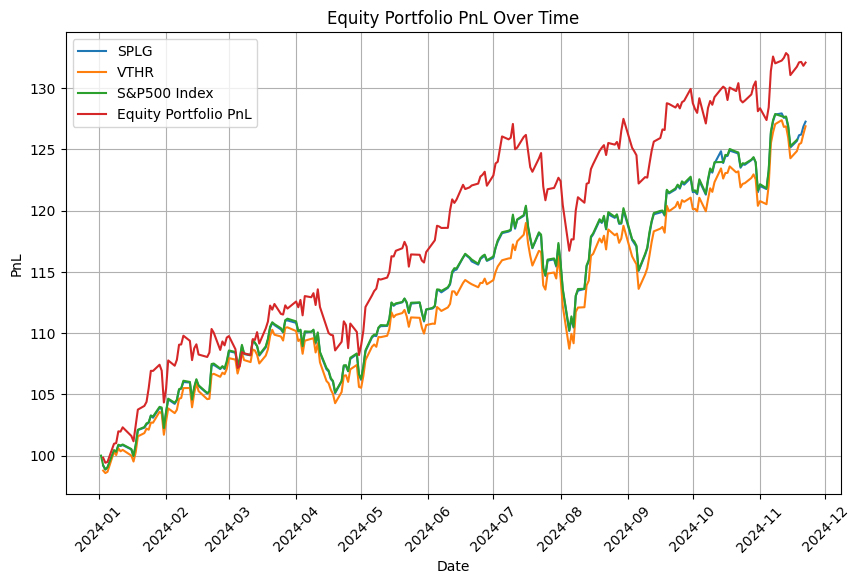

In [ ]:
# Calculate portfolio cumulative price, starting at 100
benchmark_price_index = portfolio_index_os.SP500/portfolio_index_os.SP500[0]*100
benchmark_price_SPLG = 100 * (1 + equity_benchmark_returns_os.SPLG).cumprod()
benchmark_price_VTHR = 100 * (1 + equity_benchmark_returns_os.VTHR).cumprod()
portfolio_price = 100 * (1 + equity_portfolio_returns_os).cumprod()

# Plot the portfolio price over time
plt.figure(figsize=(10, 6))
plt.plot(benchmark_price_SPLG, label="SPLG")
plt.plot(benchmark_price_VTHR, label="VTHR")
plt.plot(benchmark_price_index, label="S&P500 Index")
plt.plot(portfolio_price, label="Equity Portfolio PnL")

plt.title("Equity Portfolio PnL Over Time")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Mean Portfolio Return: 0.2195
Portfolio Return Standard Deviation: 0.1900
95% Value at Risk (VaR): -0.0888


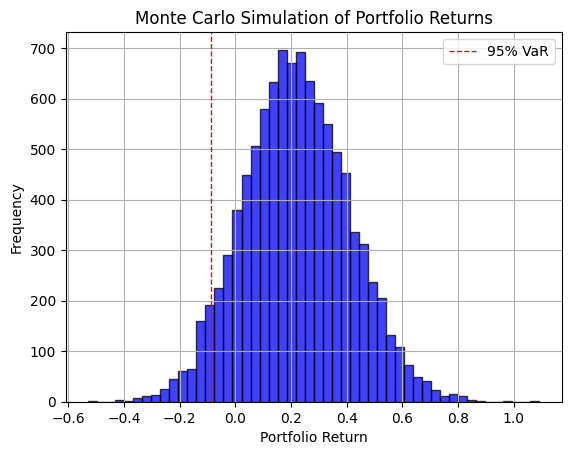

In [ ]:
value_at_risk(expected_returnBL, covar_matrix, weights_equity)

## REITS allocation

In [ ]:
# Define assets and benchmarks
assets = ['EQR', 'AVB', 'SLG', 'HIW', 'SPG', 'REG', 'WELL', 'VTR']
benchmarks = pd.read_csv('/content/US_REITs.csv').rename(columns={'Effective date ': 'Date', 'S&P United States REIT (USD) TR': 'US_REITs'})
benchmarks.Date = pd.to_datetime(benchmarks.Date)
benchmarks_os = benchmarks[benchmarks["Date"] >= "2024-01-01"]
start_date = '2015-01-01'
end_date = '2024-01-01'

<ipython-input-64-2db586bfcb5c>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  benchmarks.Date = pd.to_datetime(benchmarks.Date)


In [ ]:
reits_prices = get_data(assets, start_date, end_date)
benchmark_prices = benchmarks_os

[*********************100%***********************]  8 of 8 completed


In [ ]:
covar_matrix = risk_models.sample_cov(reits_prices)

In [ ]:
market_cap = {'EQR': 	23.03, 'AVB': 25.98, 'SLG': 45.89, 'HIW': 2.44, 'SPG': 2.89, 'REG': 11.80, 'WELL': 55.12, 'VTR': 20.42}
# Define absolute views (view tự chỉnh)
absolute_views = {
    "EQR": 0.011,
    "AVB": 0.09,
    "SLG":  0.08,
    "HIW": 0.012,
    "SPG": 0.08,
    "REG": 0.09,
    "WELL": 0.1,
    "VTR": 0.08,
}


In [ ]:
weights_reits, perfomance_reits, expected_returnBL = optimal_asset_weights(reits_prices, absolute_views, market_cap)

Expected annual return: 7.3%
Annual volatility: 28.3%
Sharpe Ratio: 0.26


In [ ]:
weights_reits

OrderedDict([('AVB', 0.17015),
             ('EQR', 0.03),
             ('HIW', 0.03),
             ('REG', 0.17508),
             ('SLG', 0.07829),
             ('SPG', 0.03),
             ('VTR', 0.06523),
             ('WELL', 0.42125)])

In [ ]:
expected_returnBL

,0
Ticker,
AVB,0.053741
EQR,0.049197
HIW,0.053119
REG,0.070663
SLG,0.083008
SPG,0.078645
VTR,0.083663
WELL,0.081840


In [ ]:
assets = ['EQR', 'AVB', 'SLG', 'HIW', 'SPG', 'REG', 'WELL', 'VTR']
benchmarks_os
start_date = '2024-01-01'
end_date = '2024-11-25'

In [ ]:
reits_prices_os = get_data(assets, start_date, end_date)

[*********************100%***********************]  8 of 8 completed


In [ ]:
reits_returns_os = reits_prices_os.pct_change().dropna()
reits_benchmark_returns_os = benchmarks_os.set_index("Date").pct_change().dropna()

In [ ]:
reits_benchmark_returns_os

,US_REITs
Date,
2024-01-02,0.010425
2024-01-03,-0.022724
2024-01-04,-0.001561
2024-01-05,-0.001780
2024-01-08,0.015587
...,...
2024-11-12,-0.013266
2024-11-13,0.005888
2024-11-14,-0.011107


In [ ]:
reits_portfolio_returns_os = portfolio_os_testing(weights_reits, reits_returns_os)[1]

In [ ]:
portfolio_os_testing(weights_reits, reits_returns_os)[3] #annualized return of OS

0.40080989000911693

In [ ]:
portfolio_os_testing(weights_reits, reits_returns_os)[2] #annualized standard deviation of OS

0.1588741041846339

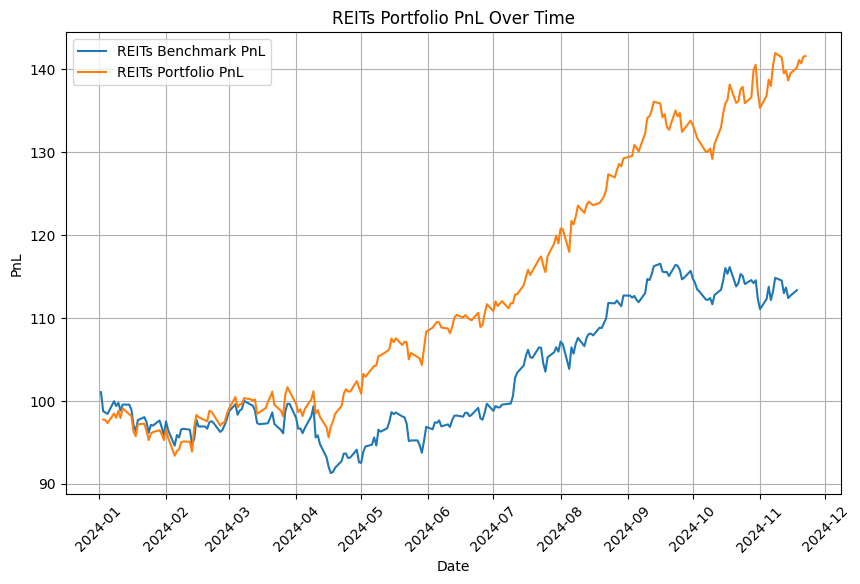

In [ ]:
# Calculate portfolio cumulative price, starting at 100
reits_benchmark_price = 100 * (1 + reits_benchmark_returns_os).cumprod()
reits_portfolio_price = 100 * (1 + reits_portfolio_returns_os).cumprod()

# Plot the portfolio price over time
plt.figure(figsize=(10, 6))
plt.plot(reits_benchmark_price, label="REITs Benchmark PnL")
plt.plot(reits_portfolio_price, label="REITs Portfolio PnL")

plt.title("REITs Portfolio PnL Over Time")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Mean Portfolio Return: 0.2459
Portfolio Return Standard Deviation: 0.1970
95% Value at Risk (VaR): -0.0363


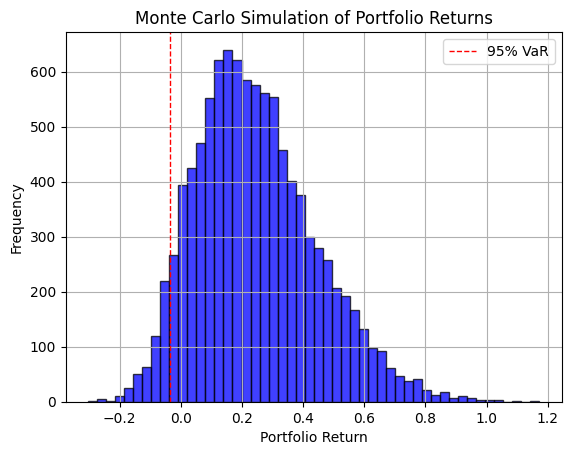

In [ ]:
value_at_risk(expected_returnBL, covar_matrix, weights_reits)

Investment-Grade Bond

In [ ]:
IGBond_prices = get_data('LQD', '2015-01-01', '2024-01-01')
IGBond_prices_os = get_data('LQD', '2024-01-01', '2024-11-25')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
IGBond_returns_os = IGBond_prices_os.pct_change().dropna()

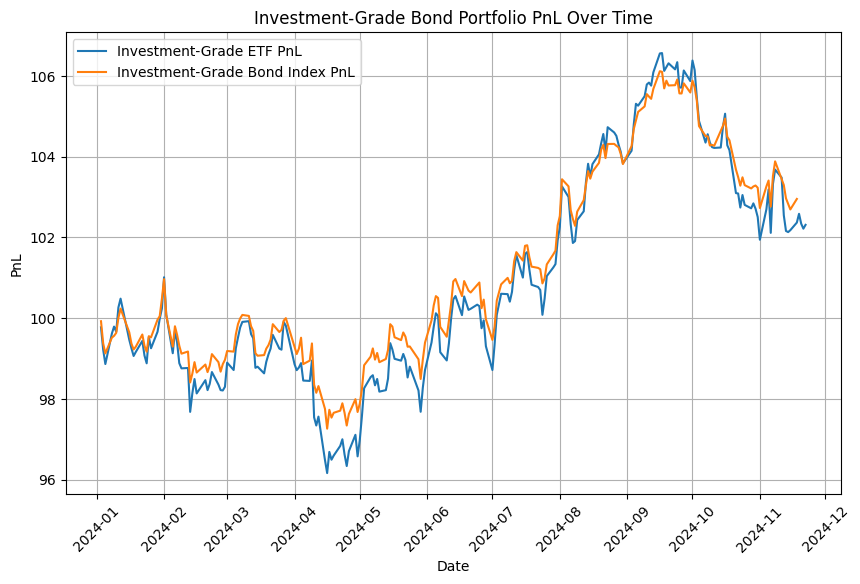

In [ ]:
# Calculate portfolio cumulative price, starting at 100
IGBond_price = (1 + IGBond_returns_os).cumprod()*100
IGBond_benchmark_price = (1 + portfolio_os.IG_CorpBond / 100).cumprod()*100

# Plot the portfolio price over time
plt.figure(figsize=(10, 6))
plt.plot(IGBond_price, label="Investment-Grade ETF PnL")
plt.plot(IGBond_benchmark_price, label="Investment-Grade Bond Index PnL")

plt.title("Investment-Grade Bond Portfolio PnL Over Time")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
(IGBond_price.iloc[-1]/IGBond_price.iloc[0])*100

,0
Ticker,
LQD,102.542476


HY bonds

In [ ]:
# Define assets and benchmarks
assets = ['HYMB', 'HYG']
start_date = '2015-01-01'
end_date = '2024-01-01'

In [ ]:
HYCorpBond_prices = get_data(assets, start_date, end_date)


[*********************100%***********************]  2 of 2 completed


In [ ]:
market_cap = {'HYG': 18.08, 'HYMB': 2.81}
# Define absolute views
absolute_views = {
    "HYG": 0.011,
    "HYMB": 0.05}

In [ ]:
covar_matrix = risk_models.sample_cov(HYCorpBond_prices)

In [ ]:
weights_HYCorpBond, perfomance_HYCorpBond, expected_returnBL = optimal_asset_weights(HYCorpBond_prices, absolute_views, market_cap)

Expected annual return: 2.4%
Annual volatility: 9.9%
Sharpe Ratio: 0.24


In [ ]:
weights_HYCorpBond

OrderedDict([('HYG', 0.2579), ('HYMB', 0.7421)])

In [ ]:
assets = ['HYMB', 'HYG']
benchmark = ['BOND']
start_date = '2024-01-01'
end_date = '2024-11-25'

In [ ]:
HYCorpBond_prices_os = get_data(assets, start_date, end_date)
benchmark_prices_os = get_data(benchmark, start_date, end_date)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
HYCorpBond_returns_os = HYCorpBond_prices_os.pct_change().dropna()
HYCorpBond_benchmark_returns_os = benchmark_prices_os.pct_change().dropna()

In [ ]:
HYCorpBond_portfolio_returns_os = portfolio_os_testing(weights_HYCorpBond, HYCorpBond_returns_os)[1]

In [ ]:
portfolio_os_testing(weights_HYCorpBond, HYCorpBond_returns_os)[3] #annualized return of OS

0.08322410880278158

In [ ]:
portfolio_os_testing(weights_HYCorpBond, HYCorpBond_returns_os)[2] #annualized standard deviation of OS

0.04484428028611536

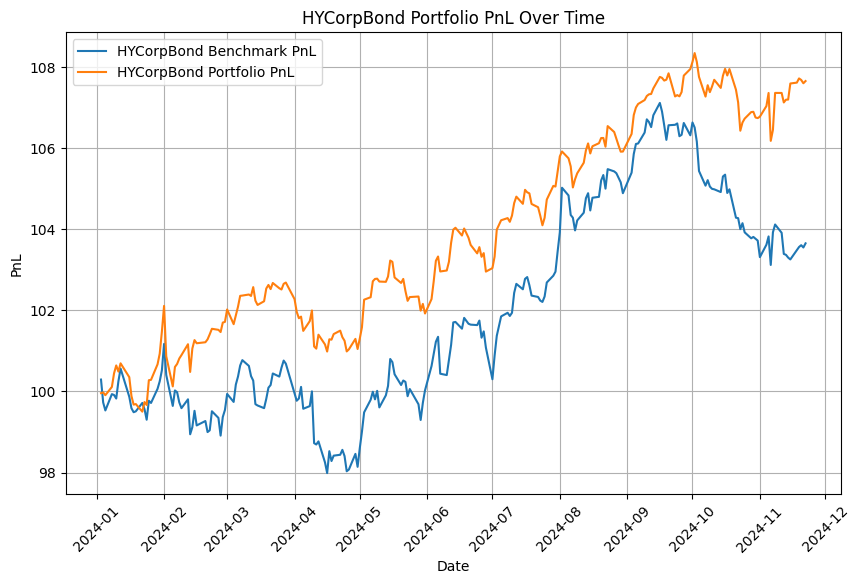

In [ ]:
# Calculate portfolio cumulative price, starting at 100
HYCorpBond_benchmark_price = (1 + HYCorpBond_benchmark_returns_os ).cumprod()*100
HYCorpBond_portfolio_price = (1 + HYCorpBond_portfolio_returns_os).cumprod()*100

# Plot the portfolio price over time
plt.figure(figsize=(10, 6))
plt.plot(HYCorpBond_benchmark_price, label="HYCorpBond Benchmark PnL")
plt.plot(HYCorpBond_portfolio_price, label="HYCorpBond Portfolio PnL")

plt.title("HYCorpBond Portfolio PnL Over Time")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
(HYCorpBond_benchmark_price.iloc[-1]/HYCorpBond_benchmark_price.iloc[0])*100

,0
Ticker,
BOND,103.347619


Mean Portfolio Return: 0.0880
Portfolio Return Standard Deviation: 0.0665
95% Value at Risk (VaR): -0.0016


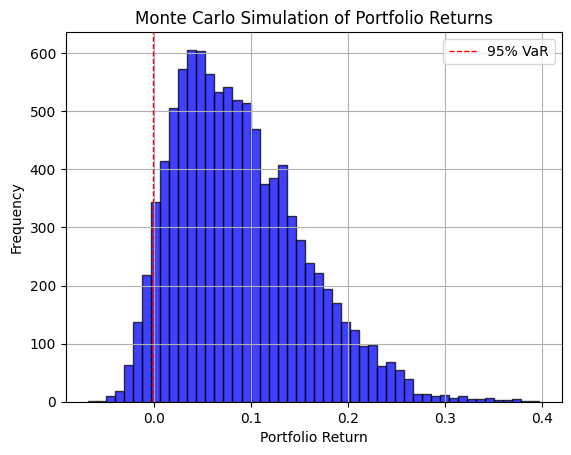

In [ ]:
value_at_risk(expected_returnBL, covar_matrix, weights_HYCorpBond)

### Aggregate Portfolio

In [ ]:
weight_array = np.array(list(aggregated_portfolio.values()))
weight_array

array([0.2381, 0.2443, 0.2616, 0.102 , 0.154 ])

In [ ]:
portfolio_os_cash = portfolio_os.copy().reset_index()
portfolio_os_cash['Date'] = pd.to_datetime(portfolio_os_cash['Date']).dt.tz_localize(None)
portfolio_os_cash[['Date', 'cash']]
merged_os_port = pd.merge(equity_portfolio_returns_os.reset_index().rename(columns = {0: 'Equity'}), IGBond_returns_os.reset_index().rename(columns = {'LQD': 'IG_Bond'}), on='Date')
merged_os_port = pd.merge(merged_os_port, HYCorpBond_portfolio_returns_os.reset_index().rename(columns = {0: 'HY_bond'}), on='Date')
merged_os_port = pd.merge(merged_os_port, reits_portfolio_returns_os.reset_index().rename(columns = {0: 'REITs'}), on='Date')
merged_os_port['Date'] = pd.to_datetime(merged_os_port['Date']).dt.tz_localize(None)
merged_os_port = pd.merge(merged_os_port, portfolio_os_cash[['Date', 'cash']], on='Date').set_index('Date')
merged_os_port.cash = merged_os_port.cash/10
merged_os_port

,Equity,IG_Bond,HY_bond,REITs,cash
Date,,,,,
2024-01-03,-0.001680,-0.002275,-0.000407,-0.022552,0.001423
2024-01-04,-0.004135,-0.005563,0.000175,-0.000587,0.001423
2024-01-05,0.000718,-0.003576,-0.000682,-0.003804,0.001423
2024-01-08,0.014893,0.007638,0.002036,0.011823,0.004269
2024-01-09,0.000530,0.001735,0.003350,-0.005166,0.001423
...,...,...,...,...,...
2024-11-12,0.001676,-0.009030,-0.002183,-0.013650,0.004909
2024-11-13,0.002950,-0.003774,0.000640,0.002006,0.001227
2024-11-14,-0.001367,-0.000277,0.000022,-0.008246,0.001227


In [ ]:
def final_portfolios_os(aggregated_portfolio, return_os):
    weight_array = np.array(list(aggregated_portfolio.values()))
    total_return = return_os.dot(weight_array)
    return total_return

In [ ]:
def calculate_security_weights(asset_allocation, security_selection):
    security_weights = {}

    # Iterate through each asset class
    for asset_class, asset_weight in asset_allocation.items():
        if asset_class in security_selection:
            # Get the security weights for this asset class
            security_class_weights = security_selection[asset_class]

            # Calculate the weight for each security
            for security, weight in security_class_weights.items():
                security_weights[security] = asset_weight * weight

    return security_weights

def plot_pie_chart(security_weights, threshold=1.0):
    # Prepare data for the pie chart
    securities = list(security_weights.keys())
    weights = list(security_weights.values())

    # Set a color palette using matplotlib (without seaborn)
    colors = plt.cm.Paired.colors  # Predefined color map "Paired"
    num_colors = len(securities)
    if num_colors > len(colors):
        colors = plt.cm.tab20c.colors  # Use tab20c if more than 12 categories

    # Create a new list for the labels that will include only significant ones
    labels = []
    percentages = []
    for sec, weight in zip(securities, weights):
        percentage = weight * 100
        if percentage > threshold:
            labels.append(f"{sec} ({percentage:.1f}%)")  # Ticker + Percentage
            percentages.append(percentage)
        else:
            labels.append('')  # Empty label for insignificant ones
            percentages.append(0)  # Empty percentage for insignificant ones

    # Plot the pie chart
    plt.figure(figsize=(10, 7))
    wedges, texts = plt.pie(
        percentages, labels=labels, startangle=140, colors=colors[:num_colors],
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}, pctdistance=0.85
    )

    # Title for the pie chart
    plt.title("Portfolio Security Weights", fontsize=16, fontweight='bold')

    # Customize the text style for labels (tickers + percentages)
    for text in texts:
        text.set_fontsize(10)  # Smaller tickers
        text.set_fontweight('bold')
        text.set_color('black')

    # Equal aspect ratio ensures that pie chart is circular
    plt.axis('equal')

    # Show the plot
    plt.show()


In [ ]:
asset_allocation = aggregated_portfolio.copy()
security_selection = {'SP500': weights_equity, 'IG_CorpBond': {'LQD': 1}, 'US_REITs': weights_reits, 'HY_CorpBond': weights_HYCorpBond, 'cash': {'Cash': 1}}

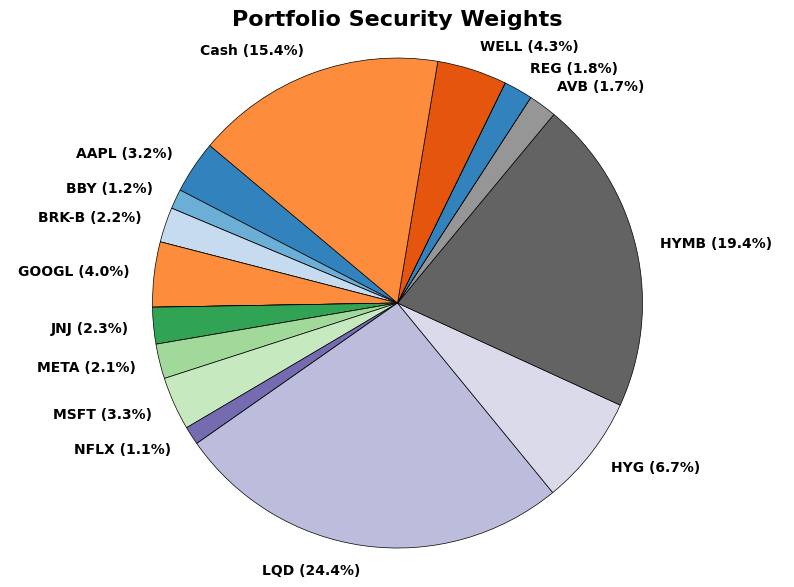

In [ ]:
plot_pie_chart(calculate_security_weights(asset_allocation, security_selection))

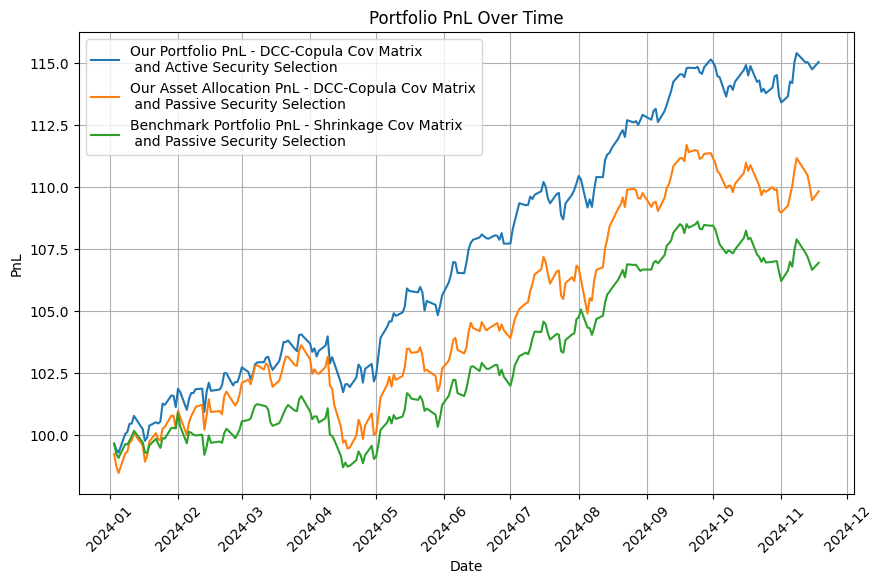

In [ ]:
# Calculate portfolio cumulative price, starting at 100
final_returns = final_portfolios_os(aggregated_portfolio, merged_os_port)
final_portfolio_price = 100 * ((1 + final_returns)*k_1).cumprod()

# Plot the portfolio price over time
plt.figure(figsize=(10, 6))
plt.plot(final_portfolio_price, label="Our Portfolio PnL - DCC-Copula Cov Matrix\n and Active Security Selection")
plt.plot(aggregated_portfolio_price, label= "Our Asset Allocation PnL - DCC-Copula Cov Matrix\n and Passive Security Selection")
plt.plot(bench_portfolio_price, label="Benchmark Portfolio PnL - Shrinkage Cov Matrix\n and Passive Security Selection")

plt.title("Portfolio PnL Over Time")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()